## NEWS_API_Analysis_Insights_and_Quality_of_Results

- The below notebook investigates the quality of the news content provided by the API in order to effectively support the use case as :

    A customer looking to build a simple news reader application. The application will support three key functionalities
         ● Browse news content and view the full text of individual articles
     
         ● Search the news for specific entities such as people, organisations and places
         
         ● Group related content together so that users do not see similar articles from multiple sources in their news stream or search results.


- It also contains some insights using some visualizations and some other processing that can be used by the customer in their application.


- The Approach to this use case is as follows:
    
    1. The Aylien provides different API endpoints that can be useful to get the data to address the above functionalities.
    
    2. I have found following two API's that can be used:
        
        i. 'http://api.core.live.gcp.aylien.com/api/v1/stories'
                - The above endpoint returns a dictionary of stories and their contents and some important metadata. I am using this API endpoint to address my first two functionalities i.e For viewing the text content and searching the news using specific entities.
        ii. 'http://api.core.live.gcp.aylien.com/api/v1/related_stories'
                - This endpoint is used for finding semantically similar stories based on the parameters you provide as inputs. I am using this API endpoint to address my third functionality i.e to group related content together.
    
    3. My main aim is access the quality of the data which is returned after firing a query to this API's. So for that, I am trying to check the quality by considering some of the below ways:
        
        i.   The API returns loads of data, so my task is to get only the relevant data that will address the above functionalities.
        
        ii.  Check if there is no missing data ?
        
        iii. Check if this data content is cleaned ? If not apply some pre-processing techniques.
        
        iv.  Try to visualize some insights from the data.
        
        v.   Explore some other data points that can be useful to check the quality.
        
        vi.  Try to dig more into a data and do some more processing that can be useful for the customer application.
        
Lets get started with this....

### Import Packages

In [1]:
#We need to import all the packages that are required to run the python code
import urllib
from urllib.request import urlopen
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from pprint import pprint as pp

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sklearn.metrics.pairwise import cosine_similarity
import operator


import matplotlib.pyplot as plt
import seaborn as sns

#Sometimes Python throws some warnings if there is any compatibility or options issue. We can suppress these warnings.
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

#### Create some default methods

- I am writing some definitions that will be used to write the data into the files, so that I no need to keep calling the API's always. 

In [2]:
# Create a raw file in the local directory in write mode. So whenever I run the cell a new file in write mode will be open.
def create_raw_file(file_location):
    raw_file = open(file_location, "w")
    raw_file.close()

# The below funtion appends the data on the file created above and hence a new merged file is formed.
def save_json_file(file_location,json_data):
    with open(file_location,'a') as json_file: 
        json.dump(json_data,json_file,indent=4) 
    json_file.close()
        
   
        
#The function takes the parameters that are set and then they are used to build a link for an API call. The API key is provided in order to have legal call to this API.
def get_raw_stories_data(raw_file_location,url,headers,params):
    
    response = requests.get(url, headers=headers, params=params).json()

    save_json_file(raw_file_location,response) 


# function to call post method of the API's
def post_raw_stories_data(raw_file_location,url,headers,params):
    
    response = requests.post(url, headers=headers, params=params).json()

    save_json_file(raw_file_location,response) 

### Targeting the First Functionality

- So here in the below cell, I am targeting to achieve my first functionality. 

- I am setting the scope to get upto 50 news stories from the country of Ireland and language of the content should be English. So, for this I am sending this into parameters that will be appended with the base url of the API.

- I have been provided with the Authorization keys which I am sending them in the headers.

- I will be also using the same scope and params for the second functionality i.e Entity Search ( discussed in later part of nb)

In [3]:
#Parameters that are passed to above function definitions

url = 'http://api.core.live.gcp.aylien.com/api/v1/stories'

headers = {
  'X-AYLIEN-NewsAPI-Application-ID': 'your application id',
  'X-AYLIEN-NewsAPI-Application-Key': 'your application key'
}

params = { 
    'source.locations.country[]': ['IE'],
    'language[]': ['en'],
    'sort_by': 'published_at',
    'sort_direction': 'desc',
    'cursor': '*',
    'per_page': 50,
}


raw_file_location="stories_raw_data.json" #Name of raw json file which gets created in local directory

print("Begin Raw News API Data Collection")

#Create a new file in write mode. Call the main get raw data funtion by providing the parameters. 
#You can call it once and keep data with you. I am commenting it for now, as I have got all the data.

#create_raw_file(raw_file_location)

#get_raw_stories_data(raw_file_location,url,headers,params)

print("\nRaw News API stories Data Collection Completed")



Begin Raw News API Data Collection

Raw News API stories Data Collection Completed


### Start working on the Data I have got

I am generating the dataframe which will contain the data that I have got from querying the API

In [4]:
# I open the raw data file on which further parsing needs to be done.
with open('stories_raw_data.json') as read_file:
    stories_data=json.load(read_file) 
    
story_df = pd.DataFrame()
for story in stories_data['stories']:
    story_data = {k:v for k,v in story.items() if k in ['id','title','body','source']}
    result = json_normalize(story_data)
    tempdf=pd.DataFrame(result)     # A dataframe is constructed from the normalize result.
    tempdf.set_index('id',inplace=True) 
    story_df=story_df.append(tempdf)
    #pp(story_data)
story_df = story_df.drop(columns=['source.id','source.locations','source.logo_url','source.name','source.rankings.alexa','source.scopes'])
story_df

,body,source.domain,source.home_page_url,title
id,,,,
27736470,UK RYANAIR PILOTS have announced a strike from...,thejournal.ie,http://www.thejournal.ie/,UK Ryanair pilots have planned to strike for a...
27736209,Jennifer Aniston has said she doesn’t feel any...,independent.ie,http://www.independent.ie/,Jennifer Aniston: Things aren’t shutting down ...
27734510,A dead newborn foal was discovered dumped on a...,dublinlive.ie,https://www.dublinlive.ie/,Disturbing image shows dead newborn foal dumpe...
27734479,Latest: Boris Johnson’s attempt to trigger an ...,breakingnews.ie,http://www.breakingnews.ie/,Latest: Boris Johnson fails in bid to trigger ...
27734397,US Vice President Mike Pence’s arrival in Icel...,independent.ie,http://www.independent.ie/,Iceland has to ease laws to allow Mike Pence’s...
27732081,MPs on Wednesday night denied Boris Johnson th...,irishtimes.com,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...
27730427,MPs on Wednesday night denied Boris Johnson th...,irishtimes.com,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...
27728618,The trustee in one-time property developer Seá...,irishtimes.com,http://www.irishtimes.com/,Seán Dunne bankruptcy trustee fighting Killile...
27728539,Two Apple employees including an engineer who ...,independent.ie,http://www.independent.ie/,Apple employees among victims of fire that kil...


#### Creating a copy the above dataframe to perform further operations

In [5]:
story_dataframe = story_df.copy()


## Access the quality

- As discussed in my approach above, I will access the quality of my data by checking the quality of data by following ways.

### Check for Missing data

- As it can be seen that there are no null values present. So the API has prcvded me with proper data.

In [6]:
story_dataframe.isnull().sum()

body                    0
source.domain           0
source.home_page_url    0
title                   0
dtype: int64

### Check for Duplicates

- As it can be seen that there are no duplicate records that we have got from the API data. So, the data is good to use for the application.

In [7]:
story_dataframe.drop_duplicates()
story_dataframe.shape

(50, 4)

### Cleaning the data

In [8]:
# function to perform some pre-processing
def cleaned_data(content_text):
    content_text = content_text.replace("\n"," ")
    content_text = content_text.replace("\t"," ")
    content_text = content_text.replace("  ", " ")

    return content_text

story_dataframe["cleaned_body"]=story_dataframe["body"].map(cleaned_data)
story_dataframe

,body,source.domain,source.home_page_url,title,cleaned_body
id,,,,,
27736470,UK RYANAIR PILOTS have announced a strike from...,thejournal.ie,http://www.thejournal.ie/,UK Ryanair pilots have planned to strike for a...,UK RYANAIR PILOTS have announced a strike from...
27736209,Jennifer Aniston has said she doesn’t feel any...,independent.ie,http://www.independent.ie/,Jennifer Aniston: Things aren’t shutting down ...,Jennifer Aniston has said she doesn’t feel any...
27734510,A dead newborn foal was discovered dumped on a...,dublinlive.ie,https://www.dublinlive.ie/,Disturbing image shows dead newborn foal dumpe...,A dead newborn foal was discovered dumped on a...
27734479,Latest: Boris Johnson’s attempt to trigger an ...,breakingnews.ie,http://www.breakingnews.ie/,Latest: Boris Johnson fails in bid to trigger ...,Latest: Boris Johnson’s attempt to trigger an ...
27734397,US Vice President Mike Pence’s arrival in Icel...,independent.ie,http://www.independent.ie/,Iceland has to ease laws to allow Mike Pence’s...,US Vice President Mike Pence’s arrival in Icel...
27732081,MPs on Wednesday night denied Boris Johnson th...,irishtimes.com,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...
27730427,MPs on Wednesday night denied Boris Johnson th...,irishtimes.com,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...
27728618,The trustee in one-time property developer Seá...,irishtimes.com,http://www.irishtimes.com/,Seán Dunne bankruptcy trustee fighting Killile...,The trustee in one-time property developer Seá...
27728539,Two Apple employees including an engineer who ...,independent.ie,http://www.independent.ie/,Apple employees among victims of fire that kil...,Two Apple employees including an engineer who ...


### Using the subset from the above dataframe as 'cleaned_dataframe' which is actually required for my functionality

In [9]:
cleaned_dataframe = story_dataframe.copy()
cleaned_dataframe = story_dataframe.drop(columns=['body','source.domain'])
cleaned_dataframe.columns = ['Source_Url','Title','Body']
cleaned_dataframe

,Source_Url,Title,Body
id,,,
27736470,http://www.thejournal.ie/,UK Ryanair pilots have planned to strike for a...,UK RYANAIR PILOTS have announced a strike from...
27736209,http://www.independent.ie/,Jennifer Aniston: Things aren’t shutting down ...,Jennifer Aniston has said she doesn’t feel any...
27734510,https://www.dublinlive.ie/,Disturbing image shows dead newborn foal dumpe...,A dead newborn foal was discovered dumped on a...
27734479,http://www.breakingnews.ie/,Latest: Boris Johnson fails in bid to trigger ...,Latest: Boris Johnson’s attempt to trigger an ...
27734397,http://www.independent.ie/,Iceland has to ease laws to allow Mike Pence’s...,US Vice President Mike Pence’s arrival in Icel...
27732081,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...
27730427,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...
27728618,http://www.irishtimes.com/,Seán Dunne bankruptcy trustee fighting Killile...,The trustee in one-time property developer Seá...
27728539,http://www.independent.ie/,Apple employees among victims of fire that kil...,Two Apple employees including an engineer who ...


In [10]:
cleaned_dataframe.shape

(50, 3)

### Getting some insights from the Data 

    1. By deriving a new column which gives the length of each story. This can be used to see how different lengths of stories have we got.


    2. By deriving a new column which states if the link that was used to get the news was secured link (https) or unsecured (http). This can be important for the customer to check if the source is a genuine source or a fake source. Generally, the secured urls are considered as the trusted sources.



In [11]:
def body_len(content):
    l = len(content)
    if l <1500:
        return 'Small_Content'
    elif l > 1500 and l < 5000:
        return 'Medium Content'
    else:
        return 'Large Content'

def check_url_quality(urls):
    
    sec = urls[0:5]
    #print(sec)
    if sec == 'https':
        return 'Secured'
    else:
        return 'Unsecured/Normal'
    
cleaned_dataframe['Security_of_Url'] = cleaned_dataframe['Source_Url'].map(check_url_quality)

cleaned_dataframe["Body_Length"] = cleaned_dataframe["Body"].map(body_len)
cleaned_dataframe

,Source_Url,Title,Body,Security_of_Url,Body_Length
id,,,,,
27736470,http://www.thejournal.ie/,UK Ryanair pilots have planned to strike for a...,UK RYANAIR PILOTS have announced a strike from...,Unsecured/Normal,Small_Content
27736209,http://www.independent.ie/,Jennifer Aniston: Things aren’t shutting down ...,Jennifer Aniston has said she doesn’t feel any...,Unsecured/Normal,Small_Content
27734510,https://www.dublinlive.ie/,Disturbing image shows dead newborn foal dumpe...,A dead newborn foal was discovered dumped on a...,Secured,Small_Content
27734479,http://www.breakingnews.ie/,Latest: Boris Johnson fails in bid to trigger ...,Latest: Boris Johnson’s attempt to trigger an ...,Unsecured/Normal,Large Content
27734397,http://www.independent.ie/,Iceland has to ease laws to allow Mike Pence’s...,US Vice President Mike Pence’s arrival in Icel...,Unsecured/Normal,Medium Content
27732081,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...,Unsecured/Normal,Medium Content
27730427,http://www.irishtimes.com/,Johnson still has a way of getting October 15t...,MPs on Wednesday night denied Boris Johnson th...,Unsecured/Normal,Medium Content
27728618,http://www.irishtimes.com/,Seán Dunne bankruptcy trustee fighting Killile...,The trustee in one-time property developer Seá...,Unsecured/Normal,Medium Content
27728539,http://www.independent.ie/,Apple employees among victims of fire that kil...,Two Apple employees including an engineer who ...,Unsecured/Normal,Large Content


### Lets do some visualizaions from the above results

The below cell shows the count of each story source url.

- It can be observed that the news were mostly taken from http://www.independent.ie/ and http://www.irishtimes.com/

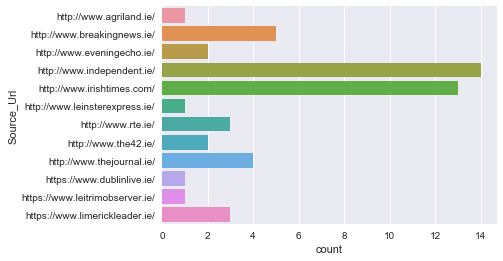

In [12]:
sns.countplot(y='Source_Url', data=cleaned_dataframe.sort_values('Source_Url'))

The below cell shows the count of each story source url if it is secured or not.

- It can be observed that the news were mostly taken from Unsecured sources, which I feel should be not that good in terms of genuiness and security.

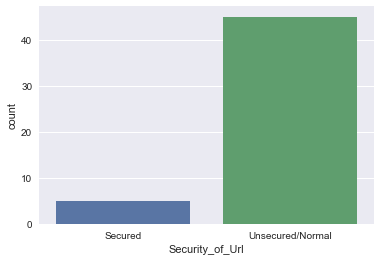

In [13]:
sns.countplot(x='Security_of_Url', data=cleaned_dataframe.sort_values('Security_of_Url'))

The below cell shows the count of stories depending on length of the each story content.

- It can be observed that, medium size news content are most preferred by this API, while Large Content stories are less preferred.

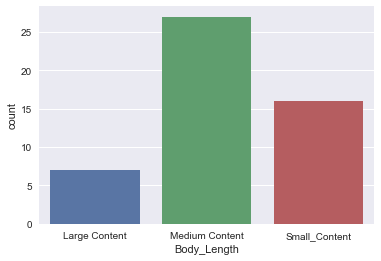

In [14]:
sns.countplot(x='Body_Length', data=cleaned_dataframe.sort_values('Body_Length'))

### Lets Dig some more into this First Functionality

- I will create a Tf-Idf matrix which can be used to get the top frequency terms from each documents and from all documents.

- Also, this matrix can be used in the prediction model.

In [15]:
# I am applying the TfIdf vectorizer on the Body content of all the stories.

all_content = cleaned_dataframe['Body']

### TF-IDF Generation

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",min_df = 3)
X_tfidf = tfidf_vectorizer.fit_transform(all_content)
print(X_tfidf.shape)

(50, 849)


In [17]:
terms= tfidf_vectorizer.get_feature_names()

#### Rank Terms based on TFIDF
##### The below two cells are just the trial that I was doing to check top ranked words in all documents. I am not using this in my next code part. It's just I wanted to check it.

In [18]:
def rank_terms( X_tfidf, terms ):
    # get the sums over each column
    sums = X_tfidf.sum(axis=0)
    #print(sums)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    #print(weights)
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

To find out top 20 tfidf terms from all the documents

In [19]:
ranking = rank_terms( X_tfidf, terms )
#print(ranking)

for i, pair in enumerate( ranking[0:20]):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. said (4.38)
02. mr (2.67)
03. limerick (2.48)
04. fai (2.35)
05. johnson (2.07)
06. election (2.03)
07. brexit (1.85)
08. october (1.66)
09. ireland (1.63)
10. deal (1.62)
11. uk (1.61)
12. house (1.60)
13. minister (1.60)
14. people (1.59)
15. mps (1.54)
16. pence (1.54)
17. prime (1.50)
18. women (1.47)
19. game (1.46)
20. cent (1.43)


#### Rank top terms from each documents

But the below function calculates the top terms from each documents.

In [20]:
def get_top_ranked_topics( terms, tfidf_array, term_index,top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( tfidf_array[term_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for i in top_indices[0:top]:
        top_terms.append( terms[i] )
    return top_terms



In [21]:
X_tfidf.shape

(50, 849)

In [22]:
num_of_top_terms = 3

##### this below cell gives the top 3 terms of each document

In [23]:
tfidf_rank =[]
for i in range(params['per_page']):
    tfidf_rank.append( get_top_ranked_topics( terms, X_tfidf.toarray(), i, num_of_top_terms ) )
    str_descriptor = ", ".join( tfidf_rank[i] )
    print("Term %02d: %s" % ( i+1, str_descriptor ) )

Term 01: action, uk, announced
Term 02: feel, don, different
Term 03: yesterday, road, died
Term 04: johnson, election, deal
Term 05: pence, president, mr
Term 06: prime, minister, labour
Term 07: labour, prime, johnson
Term 08: mr, court, ms
Term 09: school, ms, said
Term 10: star, got, didn
Term 11: deal, mps, commons
Term 12: johnson, october, deal
Term 13: board, man, defeat
Term 14: election, mps, motion
Term 15: cent, investors, company
Term 16: 2018, institute, 2020
Term 17: pence, trump, stay
Term 18: country, years, music
Term 19: programme, frame, university
Term 20: limerick, fai, club
Term 21: court, claimed, georgia
Term 22: farmers, talks, current
Term 23: win, saw, favourite
Term 24: north, ireland, department
Term 25: fai, match, uefa
Term 26: limerick, fai, game
Term 27: fai, limerick, uefa
Term 28: family, hospital, really
Term 29: tells, situation, mp
Term 30: 100, power, europe
Term 31: recognise, levels, working
Term 32: party, germany, social
Term 33: limerick, fa

#### Now along with Tf-Idf ranking there is another technique named 'Topic Modelling' that is a clustering technique which helps to find the important terms that can describe the text content. This technique can also give me some main terms that can be used as target labels for our stories, further used in prediction modelling.

### Topic Modelling

NMF Topic Models Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply matrix factorisation methods, such as Non-negative Matrix Factorisation (NMF).

The key input parameter to NMF is the number of topics to generate k. For the moment, I will pre-specify a guessed value, for demonstration purposes

In [24]:
k = 3 # no. of topics

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable result

In [25]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( X_tfidf )
H = model.components_

print(W.shape)
print(H.shape)

(50, 3)
(3, 849)


In [26]:
# function to get the top 5 terms from each topic
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms


In [27]:
# print the top 5 terms from each topic
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 5 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: johnson, election, mps, deal, minister
Topic 02: limerick, fai, uefa, match, fixing
Topic 03: said, pence, mr, president, cent


### Further steps:

- The Topic Modelling and the Tf-Idf rank_features gives us the specific terms that describes each stories. Now, as I am not having any target label, I can use these terms to decide a target label which describes each stories. For ex. [Politics, Sports, Human Affair, Accidents, Technology, Business] etc.

- Thus, using this meaningful labels, I can assign each labels to each stories correspondingly.

- Now that, each story will be having a class label, I can split the data into training and testing datasets and start applying some Machine Learning models to predict the outcomes. I believe, Naive Bayes, SVM, Logistic Regression, Random Forest models will be appropriate to be used because they perform well on Text Data.

- Evaluate them on the basis of some Evaluation measures like Precision, Recall, F1-Measure, ROC curves ( to compare different classifier's results) etc.


## Targeting Second Functionality: Entity based extraction

- As mentioned earlier I will be using the same json file that I have used for First Functionality, because that file provides me with some data that I can use for finding the news articles based on the Entities like person, organization, place etc.

- Here,for this notebook's scope I am using 'Entities' key present in the json file for exploring the Entity based Extraction. 

- However, there are more keys like 'Keywords' and 'Hashtags' that can also be used in order to promote Entity based Search.

In [28]:
# I open the raw data file on which further parsing needs to be done.
with open('stories_raw_data.json') as read_file:
    stories_data=json.load(read_file)

entity_df = pd.DataFrame()
hashtag_list =[]
for story in stories_data['stories']:
    entity_data = {k:v for k,v in story.items() if k in ['entities']}
    
    for k,v in entity_data.items():
        for i,j in v.items():
            result1 = json_normalize(j)
            df1=pd.DataFrame(result1)     # A dataframe is constructed from the normalize result.
    
            entity_df=entity_df.append(df1)
    
entity_df = entity_df.drop(columns=['indices','score'])
entity_df.columns = ['links','text','types']
entity_df.reset_index(drop=True, inplace=True)
entity_df

,links,text,types
0,http://dbpedia.org/resource/Trade_union,trade union,"[PersonFunction, Organisation, Organization]"
1,http://dbpedia.org/resource/Airport,airport,"[Aerodrome, Airport]"
2,http://dbpedia.org/resource/Lanzarote,Lanzarote,"[Place, Location, Island, PopulatedPlace]"
3,http://dbpedia.org/resource/Airline,airline,"[PersonFunction, Company]"
4,http://dbpedia.org/resource/Air_Line_Pilots_As...,Airline Pilots Association,"[TradeUnion, Organisation, Union, Agent]"
5,http://dbpedia.org/resource/Spain,Spain,"[State, Place, Location, Country, PopulatedPlace]"
6,http://dbpedia.org/resource/Strike_action,strike action,"[BaseballSeason, Stoppage]"
7,http://dbpedia.org/resource/High_Court_of_Justice,High Court,[PersonFunction]
8,http://dbpedia.org/resource/Canary_Islands,Canary Islands,"[Settlement, Place, Location, Island, Populate..."
9,http://dbpedia.org/resource/Injunction,injunction,[Remedy]


## Access the quality

- As discussed in my approach above, I will access the quality of my data by checking the quality of data by following ways.

### Check for Missing data

- As it can be seen that there are 94 null values present for the links column. 

In [29]:
entity_df.isnull().sum()

links    94
text      0
types     0
dtype: int64

- Here I can observe that wherever no links are present there the types are Organisation,Place, or Person.

- So, I can say that, API does not contains links for the stories that contains types as single entity i.e Organzation or Place or Person. 

- Hence, this quality of result should be treated.

In [30]:
nan_df = entity_df[entity_df['links'].isnull()]
nan_df

,links,text,types
22,NaN,Friends,[Organisation]
23,NaN,InStyle,[Organisation]
24,NaN,age,[Organisation]
25,NaN,Aniston,[Organisation]
35,NaN,DSPCA,[Person]
432,NaN,US,[Place]
433,NaN,Mark Pollock,[Person]
434,NaN,Pollock,[Person]
435,NaN,Ekso Bionics,[Person]
436,NaN,Ronan Langan,[Person]


In [31]:
entity_df = entity_df.dropna(axis=0)
entity_df

,links,text,types
0,http://dbpedia.org/resource/Trade_union,trade union,"[PersonFunction, Organisation, Organization]"
1,http://dbpedia.org/resource/Airport,airport,"[Aerodrome, Airport]"
2,http://dbpedia.org/resource/Lanzarote,Lanzarote,"[Place, Location, Island, PopulatedPlace]"
3,http://dbpedia.org/resource/Airline,airline,"[PersonFunction, Company]"
4,http://dbpedia.org/resource/Air_Line_Pilots_As...,Airline Pilots Association,"[TradeUnion, Organisation, Union, Agent]"
5,http://dbpedia.org/resource/Spain,Spain,"[State, Place, Location, Country, PopulatedPlace]"
6,http://dbpedia.org/resource/Strike_action,strike action,"[BaseballSeason, Stoppage]"
7,http://dbpedia.org/resource/High_Court_of_Justice,High Court,[PersonFunction]
8,http://dbpedia.org/resource/Canary_Islands,Canary Islands,"[Settlement, Place, Location, Island, Populate..."
9,http://dbpedia.org/resource/Injunction,injunction,[Remedy]


### Check for Duplicates

- It is observed that there were many duplicate records present in the results (earlier there were 1000 rows now there are 813 rows). 

- So, it is necessary to remove them, because we will get redundant results for same query, which is of no use.

In [32]:
duplicate_df = entity_df.copy()
duplicate_df.reset_index(drop=True,inplace=True)
duplicate_df = duplicate_df.iloc[duplicate_df.astype(str).drop_duplicates().index]
duplicate_df

,links,text,types
0,http://dbpedia.org/resource/Trade_union,trade union,"[PersonFunction, Organisation, Organization]"
1,http://dbpedia.org/resource/Airport,airport,"[Aerodrome, Airport]"
2,http://dbpedia.org/resource/Lanzarote,Lanzarote,"[Place, Location, Island, PopulatedPlace]"
3,http://dbpedia.org/resource/Airline,airline,"[PersonFunction, Company]"
4,http://dbpedia.org/resource/Air_Line_Pilots_As...,Airline Pilots Association,"[TradeUnion, Organisation, Union, Agent]"
5,http://dbpedia.org/resource/Spain,Spain,"[State, Place, Location, Country, PopulatedPlace]"
6,http://dbpedia.org/resource/Strike_action,strike action,"[BaseballSeason, Stoppage]"
7,http://dbpedia.org/resource/High_Court_of_Justice,High Court,[PersonFunction]
8,http://dbpedia.org/resource/Canary_Islands,Canary Islands,"[Settlement, Place, Location, Island, Populate..."
9,http://dbpedia.org/resource/Injunction,injunction,[Remedy]


### Sample Query set that can be performed on this Entity Based dataframe

- As per our functionality, I have access the data quality returned by the API, and now I am ready to check the results by querying my dataframe with some values.

- I will now copy the the duplicate_df to my main dataframe entity_df

In [33]:
entity_df = duplicate_df.copy()

In [34]:
# Query to return the story links which are of entity types 'Place' or 'Person'

selection = ['Place', 'Person']
mask = entity_df.types.apply(lambda x: any(item for item in selection if item in x))
query_entity_df = entity_df[mask]
query_entity_df

,links,text,types
2,http://dbpedia.org/resource/Lanzarote,Lanzarote,"[Place, Location, Island, PopulatedPlace]"
5,http://dbpedia.org/resource/Spain,Spain,"[State, Place, Location, Country, PopulatedPlace]"
8,http://dbpedia.org/resource/Canary_Islands,Canary Islands,"[Settlement, Place, Location, Island, Populate..."
12,http://dbpedia.org/resource/Gran_Canaria,Gran Canaria,"[Settlement, Place, Location, Island, Populate..."
14,http://dbpedia.org/resource/Girona,Girona,"[Settlement, City, Place, Location, PopulatedP..."
15,http://dbpedia.org/resource/London,London,"[Settlement, City, Place, Location, Capital, P..."
16,http://dbpedia.org/resource/Tenerife,Tenerife,"[Settlement, Place, Location, PopulatedPlace]"
17,http://dbpedia.org/resource/Jennifer_Aniston,Jennifer Aniston,"[Actress, Agent, Person]"
23,http://dbpedia.org/resource/South_Dublin,south Dublin,"[AdministrativeRegion, Location, Place, County..."
27,http://dbpedia.org/resource/Dublin,Dublin,"[City, Location, Place, Settlement, Capital, P..."


In [35]:
# Query to return the story links which are of entity types 'Organization'

selection = ['Organization']
mask = entity_df.types.apply(lambda x: any(item for item in selection if item in x))
query_entity_df = entity_df[mask]
query_entity_df

,links,text,types
0,http://dbpedia.org/resource/Trade_union,trade union,"[PersonFunction, Organisation, Organization]"
444,http://dbpedia.org/resource/Interpol,Interpol,"[Organization, Organisation, Band]"
695,http://dbpedia.org/resource/Reporters_Without_...,Reporters Without Borders,"[Agent, Organization, Organisation]"
698,http://dbpedia.org/resource/Human_Rights_Watch,Human Rights Watch,"[Non-ProfitOrganisation, Agent, Organization, ..."


## Targeting Third Functionality: Group Related Stories

- Aylien provides a endpoint which is used for finding semantically similar stories based on the parameters you provide as inputs.

- Here,for this notebook's scope I am keeping the scope as getting the stories which are having source as 'BBC'.


In [36]:
#Parameters that are passed to above function definitions

url = 'http://api.core.live.gcp.aylien.com/api/v1/related_stories'

headers = {
  'X-AYLIEN-NewsAPI-Application-ID': '226ca716',
  'X-AYLIEN-NewsAPI-Application-Key': 'fcadfe7388b91f1e6048364a8f4180d1'
}

params = { 
    'sort_by': 'published_at',
    'sort_direction': 'desc',
    'source.name[]': ['BBC'],
    'cursor': '*',
    'per_page': 20,
    'story_id': 789,
}


raw_file_location="related_stories_raw_data.json" #Name of raw json file which gets created in local directory

print("Begin Related Stories News API Data Collection")

#Create a new file in write mode.
create_raw_file(raw_file_location)

#Call the main get raw data funtion by providing the parameters.
post_raw_stories_data(raw_file_location,url,headers,params)

print("\nNews API related stories Data Collection Completed")

Begin Related Stories News API Data Collection

News API related stories Data Collection Completed


In [37]:
# I open the raw data file on which further parsing needs to be done.
with open('related_stories_raw_data.json') as read_file:
    related_stories_data=json.load(read_file) 

    
# I am taking the first part of story which is the main story around whom the other similar/related stories can be seen.
main_story = {k:v for k,v in related_stories_data.items() if k in ['story_body','story_title']}
pp(main_story)

{'story_body': 'People pass in front of a Volkswagen logo ahead of the '
               'Shanghai Auto Show, in Shanghai, China April 15, 2019. '
               'REUTERS/Aly Song\n'
               '\n'
               'SHANGHAI (Reuters) - Volkswagen wants to broaden its base of '
               'battery cell suppliers in China beyond CATL and is reviewing '
               'five companies to see whether they can meet quality and volume '
               'requirements for the multi-brand group.\n'
               '\n'
               '"We are working with five battery cell suppliers qualifying '
               'them to group level. With one or two of them it may lead to '
               'more close cooperation. In China we have chosen to do this '
               'with Chinese players," Stephan Woellenstein (55), CEO of '
               'Volkswagen China Passenger Cars said in Shanghai on Monday.\n'
               '\n'
               "The push to broaden the company's supplier base reduces V

#### Here I am putting that into one main dataframe where I will combine all the results (i.e main story and its related stories)

In [38]:
maindf= pd.DataFrame(main_story,index=[0])
main_related_df= maindf.copy()
main_related_df.columns = ['Title','Body']
main_related_df

,Title,Body
0,VW China chief says in talks with five potenti...,People pass in front of a Volkswagen logo ahea...


#### Now I will generate the other dataframe which will have all the related stories data.

In [39]:
group_df = pd.DataFrame()
for related_story in related_stories_data['related_stories']:
    #pp(related_story)
    r_stories = {k:v for k,v in related_story.items() if k in ['id','title','body']}
    result2 = json_normalize(r_stories)
    rdf=pd.DataFrame(result2)     # A dataframe is constructed from the normalize result.
    rdf.set_index('id',inplace=True) 
    group_df=group_df.append(rdf)

group_df.columns = ['Body','Title']
group_df

,Body,Title
id,,
4981062,Image copyright\n Getty Images...,Tesla to update software after car fires
19060208,Image copyright\n Getty Images...,India wants electric vehicles to drive its future
3033776,Image caption\n \n ...,Why is the white hot Chinese tech sector cooli...
14827978,Image copyright\n VCG/Getty Im...,Social angst high as Shanghai gets tough on ru...
20449304,Text of report in English by Multi-source writ...,China state media urge US to stop 'pressure' a...
18620434,Image copyright\n Getty Images...,'China's Nasdaq' board starts trading
3141053,By BBC Monitoring\n\n\nChinese analysts have f...,Chinese analysts discuss Iran-US tensions
1364949,Text of report in English by website of Singap...,"Singapore, China sign deals on trade, Belt and..."
25938826,Image copyright\n Getty Images...,Crowds force early closure of China's first Co...


In [40]:
combined_group_df = pd.concat([main_related_df,group_df],axis=0)
combined_group_df.reset_index(drop=True,inplace=True)
combined_group_df

,Body,Title
0,People pass in front of a Volkswagen logo ahea...,VW China chief says in talks with five potenti...
1,Image copyright\n Getty Images...,Tesla to update software after car fires
2,Image copyright\n Getty Images...,India wants electric vehicles to drive its future
3,Image caption\n \n ...,Why is the white hot Chinese tech sector cooli...
4,Image copyright\n VCG/Getty Im...,Social angst high as Shanghai gets tough on ru...
5,Text of report in English by Multi-source writ...,China state media urge US to stop 'pressure' a...
6,Image copyright\n Getty Images...,'China's Nasdaq' board starts trading
7,By BBC Monitoring\n\n\nChinese analysts have f...,Chinese analysts discuss Iran-US tensions
8,Text of report in English by website of Singap...,"Singapore, China sign deals on trade, Belt and..."
9,Image copyright\n Getty Images...,Crowds force early closure of China's first Co...


In [41]:
body_content = combined_group_df['Body']
body_content.shape

(21,)

### TF-IDF Generation

- Using this TfIdf matrix as an input to Cosine Similarity function.

In [42]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",min_df = 3)
X_group_tfidf = tfidf_vectorizer.fit_transform(body_content)
print(X_group_tfidf.shape)

(21, 286)


### Finding Cosine Scores

- I am finding cosine similarity scores for the main story and the related stories to check if the reated story records returned by the API are really similar/related or not

- For that I will try to the similarity scores and concat them to my main dataframe

In [43]:
# To measure the cosine similarity between the first document and rest others using Tf-idf matrix generated above.
max_cosine = 0
similar_row = 0
cosine_results =[]
for row in range(0,X_group_tfidf.shape[0]):
    cos_result = cosine_similarity( X_group_tfidf[0].toarray(), X_group_tfidf[row].toarray() )
    
    cos_scores_list = np.concatenate(cos_result).ravel().tolist() # this step converts numpy arrays to single list so that I can consider it as a Dataframe column

    cosine_results += cos_scores_list

    combined_group_df_cosine = pd.DataFrame()
    combined_group_df_cosine['Cosine_scores'] = cosine_results



#### Combining the results from two dataframes

- I can see that all the scores are positive, which means that the cosine similarity is particularly used in positive space i.e in range of [0,1]

- It can be observed that the similarity scores are around range of [0.1, 0.3] which means that, the stories are somewhat related to the main story.

- If the scores have been greater than 0.5 then the stories where supposed to very close/related to the main story.



In [44]:
new_combined_group_df = pd.concat([combined_group_df,combined_group_df_cosine], axis=1)
new_combined_group_df

,Body,Title,Cosine_scores
0,People pass in front of a Volkswagen logo ahea...,VW China chief says in talks with five potenti...,1.000000
1,Image copyright\n Getty Images...,Tesla to update software after car fires,0.258029
2,Image copyright\n Getty Images...,India wants electric vehicles to drive its future,0.243442
3,Image caption\n \n ...,Why is the white hot Chinese tech sector cooli...,0.136171
4,Image copyright\n VCG/Getty Im...,Social angst high as Shanghai gets tough on ru...,0.133916
5,Text of report in English by Multi-source writ...,China state media urge US to stop 'pressure' a...,0.232772
6,Image copyright\n Getty Images...,'China's Nasdaq' board starts trading,0.130501
7,By BBC Monitoring\n\n\nChinese analysts have f...,Chinese analysts discuss Iran-US tensions,0.125278
8,Text of report in English by website of Singap...,"Singapore, China sign deals on trade, Belt and...",0.203325
9,Image copyright\n Getty Images...,Crowds force early closure of China's first Co...,0.199961
